<a href="https://colab.research.google.com/github/Joako360/Speaker-Recognition-Notebook/blob/main/comparacion_mfccs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install speechpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import librosa
import python_speech_features as psf
import speechpy
import tensorflow as tf

import matplotlib.pyplot as plt #Pyplot graficas e representaciones
import numpy as np #NumPy para realiza operaciones numéricas
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
import os
import sklearn.mixture
import sys #sys tiene funciones con el sistema operativo.
import wave #Wave para guardar archivos de audio.
from decimal import Decimal, ROUND_HALF_UP
from math import ceil, floor
from IPython.display import Audio
from scipy import signal, fftpack as fft # SciPy se utiliza para procesamiento de señales.
from scipy.io.wavfile import read, write #Audio y read son utilizados para archivos de audio

In [ ]:
(libri2) = librosa.load(librosa.example('libri2'))
libri2

(array([-0.00, 0.00, -0.00, ..., -0.00, -0.00, -0.00], dtype=float32), 22050)

In [ ]:
Audio(libri2[0], rate=libri2[1])

In [ ]:
signal_to_power = lambda signal: np.abs(signal)**2
signal_to_power.__doc__="""
Calcula la potencia de una señal.

Parámetros:
signal (numpy.ndarray): un arreglo de numpy que representa la señal.

Retorna:
float: la potencia de la señal.
"""


power_to_signal = lambda power: np.sqrt(power)
power_to_signal.__doc__="""
Convierte una señal de potencia a su forma original.

Parámetros:
    power (array): Señal de potencia.

Retorna:
    array: Señal en su forma original.

"""

signal_to_energy = lambda signal: np.sum(signal_to_power(signal))
signal_to_energy.__doc__="""
Calcula la energia de una señal.

Parámetros:
signal (numpy.ndarray): un arreglo de numpy que representa la señal.

Retorna:
float: la energia de la señal.
"""


def power_to_db(ps, ref=1.0, top_db=80.0):
  """
  convierte una potencia en decibelios. Toma como entrada un valor de potencia y devuelve su equivalente en decibelios.

  Parámetros:

  power: float. Valor de potencia de la señal.
  Retorno:

  power_db: float. Valor en decibelios de la potencia de la señal.
  """
  #zero handling
  ps[ps==0] = np.finfo(float).eps
  db = 10.0 * np.log10(ps)
  db -= 10.0 * np.log10(ref)
  db = np.maximum(db, db.max() - top_db)
  return db

db_to_power = lambda db, ref=1.0: ref * np.power(10.0, 0.1 * db)
db_to_power.__doc__=    """
    Convierte una señal en decibelios a su correspondiente señal de potencia.

    Argumentos:
    db -- array-like, señal en decibelios

    Retorna:
    power -- array-like, señal de potencia
    """


signal_to_db = lambda signal, ref=1.0: power_to_db(signal_to_power(signal), ref)
signal_to_db.__doc__=    """
    Convierte una señal de amplitud en su nivel de decibelios (dB).

    Args:
        signal (array_like): Una señal de amplitud.

    Returns:
        array_like: El nivel de decibelios (dB) de la señal.
    """


db_to_signal = lambda db, ref=1.0: power_to_signal(db_to_power(db, ref))
db_to_signal.__doc__=    """
    Convierte una señal en decibelios a su valor de amplitud original.

    Parameters:
        db (numpy.ndarray): La señal en decibelios.

    Returns:
        numpy.ndarray: La señal en su valor de amplitud original.

    """

In [ ]:
freq_to_mel = lambda freq: 2595.0 * np.log10(1.0 + freq / 700.0)
freq_to_mel.__doc__="""
Convierte una frecuencia en Hz a una escala de Mel.

Parámetros:

freq (float): La frecuencia en hertzios a convertir a escala de Mel.
Retorno:

mels (float): El valor de la frecuencia convertido a escala de Mel.
"""

mel_to_freq = lambda mels: 700.0 * (10.0**(mels / 2595.0) - 1.0)
mel_to_freq.__doc__="""
Convierte una frecuencia de Mel a una escala en Hz.

Parámetros:

mels (float): La frecuencia en Mel a convertir a escala en Hz.
Retorno:

freq (float): El valor de la frecuencia convertido a escala en Hz.
"""

In [ ]:
normalize = lambda s: s / np.max(np.abs(s)) # normalizar audio entre -1 y 1
    # dividir cada muestra del audio por la intensidad máxima
normalize.__doc__="""
    Normaliza los datos de audio para que tengan valores entre -1 y 1.

    Parámetros:
    s (ndarray): Los datos de audio a normalizar.

    Retorna:
    ndarray: Los datos de audio normalizados.
    """


def resample(s, old_sr, new_sr):
    """
    Resamplea los datos de audio a una nueva tasa de muestreo.

    Parámetros:
    s (ndarray): Señal de audio a resamplear.
    old_sr (int): La tasa de muestreo actual de los datos de audio.
    new_sr (int): La tasa de muestreo a la que se quieren resamplear los datos
    de audio.

    Retorna:
    ndarray: Los datos de audio resampleados a la nueva tasa de muestreo.
    """
    # calcular el número de muestras del audio resamplado
    Ns = round(len(s) * float(new_sr) // old_sr)
    return signal.resample(s, Ns)


def load_audio(audio_path, filename, new_sr=None):
    """
    Carga un archivo de audio y normaliza su amplitud. Retorna los datos del
    audio y la tasa de muestreo

    Parámetros:
    audio_path (str): La ruta donde se encuentra el archivo de audio.
    filename (str): El nombre del archivo de audio.

    Retorna:
    tuple: Una tupla con dos elementos:
    s (ndarray): Los datos del audio cargado.
    sr (int): La tasa de muestreo del archivo de audio en Hz.
    """
    audio_file = audio_path + filename
    old_sr, s  = read(audio_file)
    s = normalize(s)
    if new_sr is not None:
      s = resample(s, old_sr, new_sr)
      b, a = BPF(300, (new_sr / 2) - 1, new_sr) #Filtro antialias
      s = signal.lfilter(b, a, s)
      sr = new_sr
    else:
      sr = old_sr
    return s, sr

def signals_energy_array(signal_list):
  """Calcula la energía de cada señal en una lista y retorna un array de energías."""
  energy_array = np.array([signal_to_energy(signal) for signal in signal_list])
  return energy_array


def trim_silence(s, sr, threshold=20, dt=0.2, plot=False):
    """
    Recorta las partes mudas de un audio.

    Parámetros:
    s (ndarray): Un array NumPy 1D de muestras de audio.
    threshold (int): El umbral mínimo para considerar que una muestra no es silenciosa [%].

    Retorna:
    ndarray: Un nuevo array 1D NumPy de muestras de audio con el silencio eliminado.
    """

    # Find all non-silent parts of the audio.
    nfft = 1
    while nfft < (sr*dt):
        nfft *= 2
    frames = frame_signal(s, nfft=nfft, hop_len=nfft)
    non_silent_parts = []
    E = signals_energy_array(frames)
    threshold = np.mean(E)*(threshold/100)
    for i in range(frames.shape[0]):
        if E[i] > threshold:#si el sample es menor al umbral (silencio)
            non_silent_parts.append(frames[i,:])

    # Concatenate all non-silent parts to form the trimmed audio.
    trimmed_audio = np.concatenate(non_silent_parts)
    if plot==True:
      plt.plot(E, label='Energia')
      plt.axhline(np.mean(E), linestyle='--', color='g', label='Energia Media')
      plt.axhline(threshold, linestyle='--', color='r', label='Threshold')
      plt.legend()
      plt.show()
    return trimmed_audio


def to_mono(s):
    """
    Trasforma la señarl Estereo a Mono. Si ya es Mono lo deja igual.

    Parametros:
    signal: audio de entrada

    Retorna:
    s Señal de audio en monoacustico.
    """
    if s.ndim > 1:
        s = np.mean(s, axis=1)

    return s


class VoiceSample:
  """
  Clase para trabajar con muestras de audio de voz.

  Atributos:
  sr (int): La tasa de muestreo de la muestra de audio.
  s (ndarray): Los datos de audio de la muestra.

  Métodos:
  init(self, s, sr): Inicializa la muestra de audio de voz. Si la muestra
  tiene más de un canal, se convierte a mono.
  """

  def __init__(self, s, sr, name=None):
    self.sr, self.s = sr, s
    self.name = name
    if self.s.ndim == 2:
      # convertir el audio a mono
      self.s = to_mono(self.s)


def preemphasis(s, coef=0.97):
  for n in range(len(s)):
    s[n]= s[n] - coef * s[n-1]
  return s


def deemphasis(s, coef=0.97):
  for n in range(len(s)):
    s[n] = s[n] + coef * s[n-1]
  return s


def delta(data, N=2, order=1, axis=1):
    if order < 1:
        raise ValueError("Orden de diferenciación no válido. Debe ser 1 o superior.")

    delta = data
    for i in range(order):
        delta = np.gradient(delta, N, axis=axis)
    return delta

In [ ]:
def LPF(cutoff, sr, order=1):
    """
    Genera la resultante de una señal o envolvente por un filtro pasa bajos.

    Parameters
    ----------
    s : señal o envolvente.
    cutoff : float
        frecuencia de corte.
    sr : int
        frecuencia de muestreo.
    order : int, optional
        orden. The default is 5.

    Returns
    -------
    y : señal
        resultado de haber pasado "s" por el filtro pasa bajos.

    """
    return signal.iirfilter(order, cutoff, btype='low', ftype='butter', analog=False, fs=sr)


def BPF(lowcut, highcut, sr, order=1):
    """
    Devuelve relultado de pasar señal o envolvente "s" por filtro pasa banda.

    Parameters
    ----------
    s : TYPE
        DESCRIPTION.
    lowcut : TYPE
        DESCRIPTION.
    highcut : TYPE
        DESCRIPTION.
    sr : TYPE
        DESCRIPTION.
    order : TYPE, optional
        DESCRIPTION. The default is 5.

    Returns
    -------
    y : TYPE
        DESCRIPTION.

    """
    return signal.iirfilter(order, [lowcut, highcut], btype='band', ftype='butter', analog=False, fs=sr)


def HPF(cutoff, sr, order=1):
    """
    Genera la resultante de una señal o envolvente por un filtro pasa altos.

    Parameters
    ----------
    s : señal o envolvente.
    cutoff : float
        frecuencia de corte.
    sr : int
        frecuencia de muestreo.
    order : int, optional
        orden. The default is 5.

    Returns
    -------
    y : señal
        resultado de haber pasado "s" por el filtro pasa altos.

    """
    return signal.iirfilter(order, cutoff, btype='high', ftype='butter', analog=False, fs=sr)



def two_pole_res(fc, bw, fs):
  return signal.iirpeak(fc, fc / bw, fs)

In [ ]:
(andrew) = read("/content/drive/MyDrive/audio_samples/andrew.wav")
(andrew) = andrew[0], normalize(andrew[1])
andrew

(22050, array([-0.02, -0.02, -0.02, ..., -0.01, -0.01, -0.01]))

In [ ]:
Audio(andrew[1], rate=andrew[0])

In [ ]:
aa_b, aa_a = BPF(300, 3999, 8000) #Filtro antialias
andrew_antialias = signal.lfilter(aa_b, aa_a, andrew[1]) #Filtro antialias
andrew_antialias = resample(andrew_antialias, andrew[0], 8000)
Audio(andrew_antialias, rate=8000)

In [ ]:
def frame_signal(s, nfft=1024, hop_len=None):
  """
  Divide una señal de audio en marcos solapados de tamaño nfft con un intervalo
  de saltos (hop length) de hop_len.

  Parámetros
  ----------
  s : array_like
      La señal de audio a dividir en marcos.
  nfft : int, optional
      El tamaño de los marcos. Por defecto es 1024.
  hop_len : int, optional
      El intervalo de saltos entre los marcos, en número de muestras.
      Por defecto es 512.

  Returns
  -------
  numpy.ndarray
      Una matriz 2D que contiene los marcos en el eje vertical y las muestras
      de cada marco en el eje horizontal.

  """

  # hop_len in number of samples
  hop_len = hop_len or nfft // 2
  s = np.pad(s, nfft // 2, mode='constant')
  num_frames = ceil((s.size - nfft) // hop_len) + 1
  frames = np.empty((num_frames, nfft))

  for n in range(num_frames):
      frames[n] = s[n * hop_len : (n * hop_len) + nfft]
  #dimensiones de frames: num_frames(filas) x nfft(columnas)
  return frames

In [ ]:
def window_signal(s, nfft=1024, hop_len=None, window="hann"):
  """Aplica una ventana a cada frame de una señal de audio.

  Parámetros:
  s (array): La señal de audio a dividir en frames y aplicar la ventana.
  nfft (int): El tamaño de cada frame, debe ser potencia de 2.
  window (str o array): Tipo de ventana a aplicar. Si es una cadena, debe
      ser una de las opciones disponibles en scipy.signal.get_window.
      También se puede proporcionar un array que represente una ventana
      a medida.
  hop_len (int): La cantidad de muestras que se traslaparán entre dos frames
      consecutivos.

  Retorna:
  array: Un array de frames de la señal de audio con ventana aplicada.

  """
  s_framed = frame_signal(s, nfft=nfft, hop_len=hop_len)
  window = signal.get_window(window, nfft, fftbins=True)
  s_win = s_framed * window
  return s_win

In [ ]:
s = andrew_antialias
samplerate = 8000
NFFT = 1024
NFILT = 40
NCEPT = 13
winlen = .025
winstep = .01
coef = .97

In [ ]:
psf_emph = psf.sigproc.preemphasis(s, coeff=coef)
psf_frames = psf.sigproc.framesig(psf_emph, 1024, winstep*samplerate)
psf_frames.shape

(1689, 1024)

In [ ]:
lib_emph = librosa.effects.preemphasis(s, coef=coef)
lib_frames = librosa.util.frame(lib_emph, frame_length=1024, hop_length=int(winstep*samplerate))
lib_frames.shape

(1024, 1688)

In [ ]:
spy_emph = speechpy.processing.preemphasis(s, cof=coef)
spy_frames = speechpy.processing.stack_frames(spy_emph, samplerate, frame_length=(1024/samplerate), frame_stride=winstep, zero_padding=True)
spy_frames.shape

1688 136000 1024 80.0


(1688, 1024)

In [ ]:
custom_emph = preemphasis(s, coef=coef)
custom_frame = frame_signal(s, nfft=NFFT, hop_len=int(winstep*samplerate))
custom_frame.shape

(1701, 1024)

In [ ]:
andrew_window = window_signal(s, nfft=1024)
andrew_window.shape

(266, 1024)

In [ ]:
def stft(s, nfft=1024, hop_len=None, window='hann'):
  """Calcula la Transformada de Fourier de Tiempo Corto (STFT) de la señal de audio s.

  Parámetros:
      s (ndarray): Señal de audio a analizar.
      nfft (int, optional): Tamaño de la ventana para la STFT. Por defecto 1024.
      hop_len (int, optional): Longitud del salto entre tramas. Si no se especifica, se utiliza nfft // 2.
      window (str, optional): Tipo de ventana a utilizar. Por defecto, se utiliza la ventana de Hann.

  Retorna:
      ndarray: Matriz de tamaño (T, F) que contiene los coeficientes de la STFT de la señal de audio,
      donde T es el número de tramas y F es el número de frecuencias.

  """
  hop_len = hop_len or nfft // 2
  sample_win = window_signal(s, nfft=nfft, hop_len=hop_len, window=window)
  n_frames = sample_win.shape[0]
  S_fft = np.empty((1 + nfft // 2, n_frames), dtype=np.complex64, order='F')
  for n in range(n_frames):
    frame = sample_win[n, :]
    S_fft[:, n] = np.fft.rfft(frame, n=nfft, axis=-1, norm=None)[:S_fft.shape[0]]
  return np.abs(S_fft, dtype=np.float32)


def powspec(spectrogram, nfft=1024):
  return signal_to_power(Spect) / nfft


def logpowspec(Spect, nfft=1024, norm=True):
  ps = powspec(Spect, nfft=nfft)
  lps = power_to_db(ps)
  if norm:
    return lps - np.max(lps)
  else:
    return lps

In [ ]:
custom_spec=stft(s)
custom_spec.shape

(513, 266)

In [ ]:
andrew_stft=stft(s, nfft=128)
andrew_stft.shape

(65, 2126)

In [ ]:
psf_spec = psf.sigproc.logpowspec(psf_frames,NFFT)
psf_spec.shape

(1689, 513)

In [ ]:
lib_spec = librosa.stft(lib_emph, n_fft=NFFT, win_length=1024, hop_length=int(winstep*samplerate))
lib_spec = librosa.amplitude_to_db(np.abs(lib_spec), ref=np.max)
lib_spec.shape

(513, 1701)

In [ ]:
import tensorflow_io as tfio
tf_stft = tf.signal.stft(s, int(winlen*samplerate), int(winstep*samplerate))
tf_spec = tf.abs(tf_stft)
tf_spec = 10 * tf.math.log(tf.math.square(tf_spec))
tf_spec = tf_spec - tf.math.reduce_max(tf_spec)
tf_spec.shape

TensorShape([1698, 129])

In [ ]:
spy_spec = speechpy.processing.log_power_spectrum(spy_frames, fft_points=NFFT)
spy_frames.shape

(1688, 1024)

In [ ]:
custom_spec = logpowspec(s, nfft=NFFT)
custom_frame.shape

(1701, 1024)

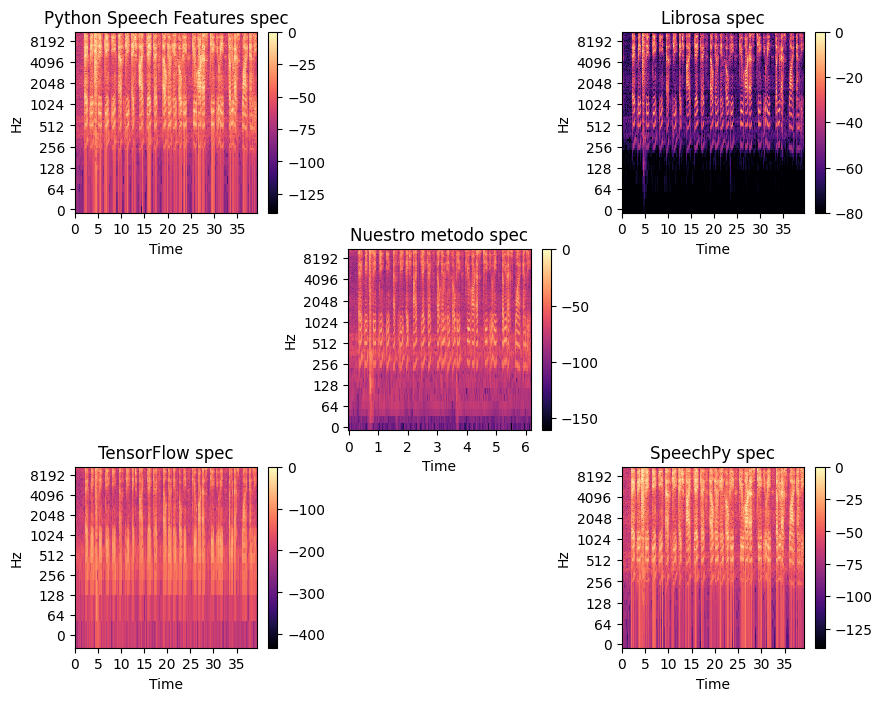

In [ ]:
layout = [['psf',  '.',      'lib'],
          ['.',    'custom', '.'  ],
          ['tf',   '.',      'spy']]
fig, axd = plt.subplot_mosaic(layout, figsize=(10,8))
img = librosa.display.specshow(psf_spec.T, y_axis='log', x_axis='time', ax=axd['psf'])
fig.colorbar(img, ax=axd['psf'])
axd['psf'].set(title='Python Speech Features spec')
img = librosa.display.specshow(tf_spec.numpy().T, y_axis='log', x_axis='time', ax=axd['tf'])
fig.colorbar(img, ax=axd['tf'])
axd['tf'].set(title='TensorFlow spec')
img = librosa.display.specshow(custom_spec, y_axis='log', x_axis='time', ax=axd['custom'])
fig.colorbar(img, ax=axd['custom'])
axd['custom'].set(title='Nuestro metodo spec')
img = librosa.display.specshow(lib_spec, y_axis='log', x_axis='time', ax=axd['lib'])
fig.colorbar(img, ax=axd['lib'])
axd['lib'].set(title='Librosa spec')
img = librosa.display.specshow(spy_spec.T, y_axis='log', x_axis='time', ax=axd['spy'])
fig.colorbar(img, ax=axd['spy'])
axd['spy'].set(title='SpeechPy spec')
plt.show()

In [ ]:
def get_filter_points(nfilt=13, nfft=1024, sr=8000, fmin=300, fmax=None):
    """
    Calcula los puntos de filtro en una escala Mel, dados los límites inferior y superior de frecuencia,
    el número de filtros, el tamaño de la FFT y la frecuencia de muestreo.

    Args:
    fmin (float, optional): Frecuencia mínima en Hz. Valor por defecto es 20.
    fmax (float, optional): Frecuencia máxima en Hz. Valor por defecto es 22050.
    nfilt (int, optional): Número de filtros a crear. Valor por defecto es 13.
    nfft (int, optional): Tamaño de la transformada rápida de Fourier (FFT). Valor por defecto es 1024.
    sr (int, optional): Frecuencia de muestreo en Hz. Valor por defecto es 44100.

    Returns:
    numpy.ndarray, numpy.ndarray: Un arreglo con los puntos de filtro y un arreglo con las frecuencias en Hz.

    """
    fmax = fmax or sr/2
    assert fmax <= sr/2, "fmax is greater than samplerate/2"
    # compute points evenly spaced in mels
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    mels = np.linspace(fmin_mel, fmax_mel, num=nfilt+2)
    freqs = mel_to_freq(mels)

    return np.floor((nfft + 1) * freqs / sr ).astype(int)[:], freqs

In [ ]:
def mel_fbank(filter_points, hz_freqs, nfft=1024, norm=True):
    """
    Calcula los filtros de Mel.

    Parameters
    ----------
    filter_points : numpy.ndarray
        Array de enteros que indica los índices de frecuencia para cada filtro.
    nfft : int, optional
        Tamaño de la transformada de Fourier de corto tiempo (STFT), por defecto 1024.

    Returna
    -------
    numpy.ndarray
        Matriz de forma (num_filtros, nfft/2+1) que representa los filtros de Mel.
    """

    filters = np.zeros((len(filter_points) - 2, nfft // 2 + 1))

    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    if norm:
      enorm = 2.0 / (hz_freqs[2:filters.shape[0]+2] - hz_freqs[:filters.shape[0]])#energy normal
      filters *= enorm[:, np.newaxis]
    return filters

In [ ]:
psf_fb = psf.get_filterbanks(nfilt=NFILT, nfft=NFFT, samplerate=samplerate)

spy_fb = speechpy.feature.filterbanks(num_filter=NFILT, coefficients=NFFT//2+1, sampling_freq=samplerate)

lib_fb = librosa.filters.mel(sr=samplerate, n_fft=NFFT, n_mels=NFILT)
# fix librosa normalized version
lib_fb /= np.max(lib_fb, axis=-1)[:, None]


In [ ]:
def mfcc (s, sr,	hop_len=None,	numcep=13,	nfilt=40,	nfft=1024, fmin=300, fmax=None,	lifter=0,	winfunc='hann'):
  S_stft = stft(s, nfft=nfft, hop_len=hop_len, window=winfunc)
  pow_S = powspec(S_stft, nfft=nfft)
  fmax = fmax or sr // 2
  filter_points, mel_freqs = get_filter_points(nfilt=nfilt, nfft=nfft, sr=sr, fmin=fmin, fmax=fmax)
  filters = mel_fbank(filter_points, mel_freqs)
  pow_S_filtered = np.dot(filters, np.transpose(pow_S))
  coeffs = power_to_db(pow_S_filtered)
  mfccs = fft.dct(coeffs, type=2, axis=0, norm='ortho')[:numcep]
  return mfccs


def get_features(vs):
    """
    Extrae características MFCC de una muestra de audio de voz.

    Parámetros:
    vs (VoiceSample): La muestra de audio de voz de la que se extraerán las
    características.

    Retorna:
    ndarray: Un array de numpy con las características MFCC de la muestra de
    audio.
    """
    s, sr = vs.s, vs.sr
    s = trim_silence(s, sr)
    Audio(s, rate=sr)
    mfccs = mfcc(s, sr)
    mfcc_delta = delta(mfccs)
    mfcc_delta2 = delta(mfccs, order=2)
    feats = np.concatenate((mfccs, mfcc_delta, mfcc_delta2))
    return feats

In [ ]:
def tf_signal_mfcc(signals, sample_rate, frame_length=1024, frame_step=256,
                   num_mel_bins=80, numcep=13, lower_edge_hertz=80, upper_edge_hertz=7600):
  # A 1024-point STFT with frames of 64 ms and 75% overlap.
  stft = tf.signal.stft(signals, frame_length, frame_step)
  spectrogram = tf.abs(stft)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = stft.shape[-1]
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
  # Compute MFCCs from log_mel_spectrograms and take the first 13.
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[...,:numcep]
  return mfccs


def tf_ops_mfcc(sample, sample_rate, window_size_samples=1024,
                window_stride_samples=256, dct_coefficient_count=13):
  # spectrogram computation
  spectrogram = tf.raw_ops.AudioSpectrogram(
      input=sample,
      window_size=window_size_samples,
      stride=window_stride_samples
      )

  # mfcc computation
  mfcc_features = tf.raw_ops.Mfcc(
      spectrogram=spectrogram,
      sample_rate=sample_rate,
      dct_coefficient_count=dct_coefficient_count
  )
  return mfcc_features

In [ ]:
s = libri2[0]
samplerate = libri2[1]
NFFT = 1024
NFILT = 40
NCEPT = 13
winlen = .025
winstep = .01
coef = .97

In [ ]:
psf_mfccs=psf.mfcc(s, samplerate, winlen=winlen, winstep=winstep, numcep=NCEPT,
                   nfilt=NFILT, nfft=NFFT, preemph=coef, ceplifter=0,
                   winfunc=np.hanning, appendEnergy=False)
psf_mfccs = psf_mfccs.T

In [ ]:
tf_mfccs = tf_signal_mfcc(s, samplerate, num_mel_bins=NFILT, numcep=NCEPT)
tf_mfccs = tf_mfccs.numpy().T

In [ ]:
lib_emph = librosa.effects.preemphasis(s, coef=coef)
lib_mfccs = librosa.feature.mfcc(y=lib_emph, sr=samplerate, n_mfcc=NCEPT, dct_type=2, n_fft=NFFT, n_mels=NFILT)

In [ ]:
spy_emph = speechpy.processing.preemphasis(s, cof=coef)
spy_mfccs = speechpy.feature.mfcc(spy_emph, samplerate, frame_length=winlen,
                                  frame_stride=winstep, num_cepstral=NCEPT,
                                  num_filters=NFILT, fft_length=NFFT)
spy_mfccs = spy_mfccs.T

In [ ]:
custom_emph = preemphasis(s, coef=coef)
custom_hoplen = int(Decimal(winstep * samplerate).quantize(Decimal('1'), rounding=ROUND_HALF_UP))
custom_mfccs = mfcc(
    s, samplerate, hop_len=custom_hoplen,	numcep=NCEPT,
    nfilt=NFILT,	nfft=NFFT,	lifter=0,	winfunc='hann'
    )

ValueError: ignored

In [ ]:
layout = [['psf',  '.',      'lib'],
          ['.',    'custom', '.'  ],
          ['tf',   '.',      'spy']]
fig, axd = plt.subplot_mosaic(layout, figsize=(10,8))
img = librosa.display.specshow(psf_mfccs, x_axis='time', ax=axd['psf'])
fig.colorbar(img, ax=axd['psf'])
axd['psf'].set(title='Python Speech Features MFCC')
img = librosa.display.specshow(tf_mfccs, x_axis='time', ax=axd['tf'])
fig.colorbar(img, ax=axd['tf'])
axd['tf'].set(title='TensorFlow MFCC')
img = librosa.display.specshow(custom_mfccs, x_axis='time', ax=axd['custom'])
fig.colorbar(img, ax=axd['custom'])
axd['custom'].set(title='Nuestro metodo MFCC')
img = librosa.display.specshow(lib_mfccs, x_axis='time', ax=axd['lib'])
fig.colorbar(img, ax=axd['lib'])
axd['lib'].set(title='Librosa MFCC')
img = librosa.display.specshow(spy_mfccs, x_axis='time', ax=axd['spy'])
fig.colorbar(img, ax=axd['spy'])
axd['spy'].set(title='SpeechPy MFCC')

In [ ]:
psf_delta=psf.base.delta(custom_mfccs, 3)


In [ ]:
lib_delta = librosa.feature.delta(custom_mfccs, width=3)

In [ ]:
spy_delta = speechpy.processing.derivative_extraction(custom_mfccs, 3)

In [ ]:
custom_delta = delta(custom_mfccs, 3)

In [ ]:
layout = [['psf',    'lib'],
          ['custom', 'spy'  ]]
fig, axd = plt.subplot_mosaic(layout, figsize=(10,8))
img = librosa.display.specshow(psf_delta, x_axis='time', ax=axd['psf'])
fig.colorbar(img, ax=axd['psf'])
axd['psf'].set(title='Python Speech Features delta')
img = librosa.display.specshow(custom_delta, x_axis='time', ax=axd['custom'])
fig.colorbar(img, ax=axd['custom'])
axd['custom'].set(title='Nuestro metodo delta')
img = librosa.display.specshow(lib_delta, x_axis='time', ax=axd['lib'])
fig.colorbar(img, ax=axd['lib'])
axd['lib'].set(title='Librosa delta')
img = librosa.display.specshow(spy_delta, x_axis='time', ax=axd['spy'])
fig.colorbar(img, ax=axd['spy'])
axd['spy'].set(title='SpeechPy delta')

test.mp3